# Importations et configuration

In [1]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, classification_report)
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from scipy.signal import welch
from tqdm import tqdm
import tensorflow as tf
import warnings
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modèles de machine learning
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore', category=UserWarning)
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(False)

# Configuration
DATA_DIR = '.'
RANDOM_STATE = 42
N_SPLITS = 5
EPOCHS = 100
BATCH_SIZE = 32

# Liste des fichiers avec labels
files = [
    ('AO_10.csv', 1), ('AO_11.csv', 1), ('AO_12.csv', 1), ('AO_13.csv', 1),
    ('AO_14.csv', 1), ('AO_15.csv', 1), ('AO_16.csv', 1), ('AO_17.csv', 1),
    ('AO_18.csv', 1), ('AO_19.csv', 1), ('AO_2.csv', 1), ('AO_22.csv', 1),
    ('AO_23.csv', 1), ('AO_24.csv', 1), ('AO_3.csv', 1), ('AO_4.csv', 1),
    ('AO_6.csv', 1), ('AO_20.csv', 1), ('AO_21.csv', 1), ('AO_7.csv', 1),
    ('AO_8.csv', 1), ('AO_9.csv', 1),
    ('SO_1.csv', 0), ('SO_10.csv', 0), ('SO_11.csv', 0), ('SO_12.csv', 0),
    ('SO_13.csv', 0), ('SO_14.csv', 0), ('SO_16.csv', 0), ('SO_17.csv', 0),
    ('SO_19.csv', 0), ('SO_2.csv', 0), ('SO_20.csv', 0), ('SO_23.csv', 0),
    ('SO_24.csv', 0), ('SO_25.csv', 0), ('SO_3.csv', 0), ('SO_4.csv', 0),
    ('SO_5.csv', 0), ('SO_21.csv', 0), ('SO_26.csv', 0), ('SO_6.csv', 0),
    ('SO_7.csv', 0), ('SO_8.csv', 0)
]

# Fonctions utilitaires

In [2]:
def set_seeds(seed):
    """Fixe toutes les graines aléatoires pour la reproductibilité"""
    np.random.seed(seed)
    tf.random.set_seed(seed)

def extract_detector_features(df, detector_num):
    """Extrait les caractéristiques pour un détecteur spécifique."""
    features = {}
    suffix = f'.{detector_num-1}' if detector_num > 1 else ''
    
    for channel in range(1, 17):
        red_col = f'RED{channel}{suffix}'
        ir_col = f'IR{channel}{suffix}'
        
        if red_col not in df.columns or ir_col not in df.columns:
            continue
            
        red_signal = df[red_col].values
        ir_signal = df[ir_col].values
        hbo = red_signal - ir_signal
        hbr = ir_signal - red_signal
        
        prefix = f'D{detector_num}C{channel}'
        
        features.update({
            f'{prefix}RED_mean': np.mean(red_signal),
            f'{prefix}RED_std': np.std(red_signal),
            f'{prefix}IR_mean': np.mean(ir_signal),
            f'{prefix}HBO_mean': np.mean(hbo),
            f'{prefix}HBR_mean': np.mean(hbr),
        })
        
        diff_red = np.diff(red_signal)
        features[f'{prefix}RED_diff_std'] = np.std(diff_red)
        
        if len(red_signal) > 10:
            f, psd = welch(red_signal, fs=10)
            features[f'{prefix}PSD_peak'] = np.max(psd)
            features[f'{prefix}PSD_peak_freq'] = f[np.argmax(psd)]
    
    return features

def load_and_process_data(files):
    """Charge et traite tous les fichiers de données."""
    all_features = []
    labels = []
    
    for filename, label in tqdm(files, desc="Traitement des fichiers"):
        filepath = os.path.join(DATA_DIR, filename)
        if not os.path.exists(filepath):
            print(f"Avertissement: Fichier {filename} non trouvé. Ignoré.")
            continue
            
        df = pd.read_csv(filepath)
        file_features = {}
        
        for detector in range(1, 33):
            detector_features = extract_detector_features(df, detector)
            file_features.update(detector_features)
        
        all_red = df.filter(regex='RED').values.flatten()
        all_ir = df.filter(regex='IR').values.flatten()
        
        file_features.update({
            'global_RED_mean': np.mean(all_red),
            'global_RED_std': np.std(all_red),
            'global_IR_mean': np.mean(all_ir),
            'global_RED_IR_ratio': np.mean(all_red)/(np.mean(all_ir)+1e-10),
        })
        
        all_features.append(file_features)
        labels.append(label)
    
    return pd.DataFrame(all_features), np.array(labels)

#  Construction des modèles

In [3]:
def build_mlp_model(input_shape):
    """Construit un modèle MLP"""
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def build_gru_model(input_shape):
    """Construit un modèle GRU"""
    model = Sequential([
        Input(shape=(1, input_shape)),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def build_bilstm_model(input_shape):
    """Construit un modèle BiLSTM"""
    model = Sequential([
        Input(shape=(1, input_shape)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def get_fresh_ml_model(model_name):
    """Retourne une nouvelle instance d'un modèle ML"""
    models = {
        "SVM": lambda: SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
        "Logistic Regression": lambda: LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        "Random Forest": lambda: RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        "KNN": lambda: KNeighborsClassifier(n_neighbors=5),
        "XGBoost": lambda: XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0)
    }
    return models[model_name]()

# Fonction d'évaluation

In [4]:
def evaluate_model_5fold_corrected(model_builder, model_type, X_raw, y, model_name):
    """
    Version CORRIGÉE de la validation croisée 5-fold SANS data leakage
    
    Args:
        model_builder: Fonction qui construit le modèle (DL) ou nom du modèle (ML)
        model_type: Type de modèle ('DL' ou 'ML')
        X_raw: Données brutes (non prétraitées)
        y: Labels
        model_name: Nom du modèle
    
    Returns:
        dict: Résultats de validation croisée
    """
    print(f"\n=== Évaluation {model_name} - CV 5-fold CORRIGÉE ===")
    
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    fold_results = {
        'accuracy': [], 'precision': [], 'recall': [], 
        'f1': [], 'roc_auc': [], 'train_time': [], 'test_time': []
    }
    
    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    
    print(f"Répartition des classes: {np.bincount(y)}")
    print(f"Données brutes: {X_raw.shape}, NaN: {pd.isna(X_raw).sum().sum()}")
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_raw, y), 1):
        print(f"\nFold {fold}/{N_SPLITS}")
        
        # Division des données BRUTES
        X_train_raw, X_val_raw = X_raw[train_idx], X_raw[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        print(f"  Train: {len(X_train_raw)} échantillons, Val: {len(X_val_raw)} échantillons")
        print(f"  Train classes: {np.bincount(y_train)}, Val classes: {np.bincount(y_val)}")
        
        # ÉTAPE 1: IMPUTATION séparée pour éviter le data leakage
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_raw)    # Fit sur train
        X_val_imputed = imputer.transform(X_val_raw)            # Transform sur val
        
        print(f"    Après imputation - Train NaN: {pd.isna(X_train_imputed).sum().sum()}, "
              f"Val NaN: {pd.isna(X_val_imputed).sum().sum()}")
        
        # ÉTAPE 2: NORMALISATION séparée pour éviter le data leakage
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)  # Fit sur train
        X_val_scaled = scaler.transform(X_val_imputed)          # Transform sur val
        
        # ÉTAPE 3: Construction du modèle
        if model_type == 'DL':
            # Fixer les graines pour la reproductibilité
            set_seeds(RANDOM_STATE + fold)
            
            model = model_builder(X_train_scaled.shape[1])
            
            # Préparation des données selon le type de modèle DL
            if model_name in ['GRU', 'BiLSTM']:
                X_train_final = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
                X_val_final = X_val_scaled.reshape(-1, 1, X_val_scaled.shape[1])
            else:  # MLP
                X_train_final = X_train_scaled
                X_val_final = X_val_scaled
        else:  # ML
            # Créer une NOUVELLE instance du modèle pour chaque fold
            model = get_fresh_ml_model(model_name)
            X_train_final = X_train_scaled
            X_val_final = X_val_scaled
        
        # ÉTAPE 4: Entraînement
        start_train = timer()
        if model_type == 'DL':
            early_stopping = EarlyStopping(
                monitor='val_loss', patience=15, 
                restore_best_weights=True, verbose=0
            )
            
            history = model.fit(
                X_train_final, y_train,
                validation_data=(X_val_final, y_val),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=[early_stopping],
                verbose=0
            )
            
            epochs_trained = len(history.history['loss'])
            print(f"    Entraînement arrêté à l'époque {epochs_trained}")
            
        else:  # ML
            model.fit(X_train_final, y_train)
        
        train_time = timer() - start_train
        
        # ÉTAPE 5: Prédiction
        start_test = timer()
        if model_type == 'DL':
            y_proba = model.predict(X_val_final, verbose=0).flatten()
        else:  # ML
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_val_final)[:, 1]
            else:  # SVM sans probabilité
                y_proba = model.decision_function(X_val_final)
                # Normaliser les scores entre 0 et 1
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-10)
        
        test_time = timer() - start_test
        y_pred = (y_proba > 0.5).astype(int)
        
        # ÉTAPE 6: Calcul des métriques
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)
        
        try:
            roc_auc = roc_auc_score(y_val, y_proba)
        except ValueError:
            roc_auc = float('nan')
        
        # Stockage des résultats
        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['f1'].append(f1)
        fold_results['roc_auc'].append(roc_auc)
        fold_results['train_time'].append(train_time)
        fold_results['test_time'].append(test_time)
        
        # Pour calcul global
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)
        
        # Affichage des résultats du fold
        print(f"    Accuracy: {accuracy:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
        print(f"    Temps - Train: {train_time:.2f}s, Test: {test_time:.4f}s")
    
    # Calcul des statistiques finales
    results = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'train_time', 'test_time']:
        values = fold_results[metric]
        clean_values = [v for v in values if not np.isnan(v)]
        if clean_values:
            results[f'{metric}_mean'] = np.mean(clean_values)
            results[f'{metric}_std'] = np.std(clean_values)
        else:
            results[f'{metric}_mean'] = float('nan')
            results[f'{metric}_std'] = float('nan')
    
    # Matrice de confusion globale
    results['confusion_matrix'] = confusion_matrix(all_y_true, all_y_pred)
    results['classification_report'] = classification_report(
        all_y_true, all_y_pred, 
        target_names=["Sans objectif", "Avec objectif"],
        output_dict=True
    )
    
    return results, fold_results

# Chargement des données

In [5]:
# Chargement et traitement des données
print("Chargement et traitement des données...")
start_time = time.time()
features_df, labels = load_and_process_data(files)
print(f"Données chargées et traitées en {time.time() - start_time:.2f} secondes")

print(f"\nDimensions du dataset: {features_df.shape}")
print(f"Valeurs manquantes: {features_df.isna().sum().sum()}")
print("Répartition des classes:")
print(pd.Series(labels).value_counts().sort_index())

# IMPORTANT: Garde les données BRUTES (sans prétraitement global)
X_raw = features_df.values
y = labels

Chargement et traitement des données...


Traitement des fichiers:  68%|██████████████████████████████████████▊                  | 30/44 [01:09<00:28,  2.05s/it]

Avertissement: Fichier SO_19.csv non trouvé. Ignoré.


Traitement des fichiers: 100%|█████████████████████████████████████████████████████████| 44/44 [01:45<00:00,  2.40s/it]


Données chargées et traitées en 106.10 secondes

Dimensions du dataset: (43, 4100)
Valeurs manquantes: 2222
Répartition des classes:
0    21
1    22
Name: count, dtype: int64


# Configuration des modèles à évaluer

In [6]:
# Dictionnaire des modèles à évaluer
models_to_evaluate = {
    # Modèles Deep Learning (fonctions)
    "MLP": (build_mlp_model, "DL"),
    "GRU": (build_gru_model, "DL"), 
    "BiLSTM": (build_bilstm_model, "DL"),
    
    # Modèles Machine Learning (noms pour get_fresh_ml_model)
    "SVM": ("SVM", "ML"),
    "Logistic Regression": ("Logistic Regression", "ML"),
    "Random Forest": ("Random Forest", "ML"),
    "KNN": ("KNN", "ML"),
    "XGBoost": ("XGBoost", "ML")
}

# Évaluation des modèles

In [7]:
# Évaluation de tous les modèles
all_results = {}
detailed_results = {}

print(f"\n{'='*70}")
print("VALIDATION CROISÉE 5-FOLD CORRIGÉE (SANS DATA LEAKAGE)")
print(f"{'='*70}")

for model_name, (model_builder, model_type) in models_to_evaluate.items():
    start_time = time.time()
    results, fold_details = evaluate_model_5fold_corrected(
        model_builder, model_type, X_raw, y, model_name
    )
    execution_time = time.time() - start_time
    
    all_results[model_name] = results
    detailed_results[model_name] = fold_details
    
    # Affichage des résultats moyens
    print(f"\n--- RÉSULTATS MOYENS {model_name} ---")
    print(f"Accuracy    : {results['accuracy_mean']:.3f} (±{results['accuracy_std']:.3f})")
    print(f"F1-score    : {results['f1_mean']:.3f} (±{results['f1_std']:.3f})")
    print(f"Precision   : {results['precision_mean']:.3f} (±{results['precision_std']:.3f})")
    print(f"Recall      : {results['recall_mean']:.3f} (±{results['recall_std']:.3f})")
    print(f"ROC AUC     : {results['roc_auc_mean']:.3f} (±{results['roc_auc_std']:.3f})")
    print(f"Temps total : {execution_time:.2f}s")
    
    print("\nMatrice de confusion globale:")
    print(results['confusion_matrix'])
    print(f"\n{'-'*50}")


VALIDATION CROISÉE 5-FOLD CORRIGÉE (SANS DATA LEAKAGE)

=== Évaluation MLP - CV 5-fold CORRIGÉE ===
Répartition des classes: [21 22]
Données brutes: (43, 4100), NaN: 2222

Fold 1/5
  Train: 34 échantillons, Val: 9 échantillons
  Train classes: [17 17], Val classes: [4 5]
    Après imputation - Train NaN: 0, Val NaN: 0
    Entraînement arrêté à l'époque 16
    Accuracy: 0.667, F1: 0.727, ROC-AUC: 0.750
    Temps - Train: 10.77s, Test: 0.4485s

Fold 2/5
  Train: 34 échantillons, Val: 9 échantillons
  Train classes: [17 17], Val classes: [4 5]
    Après imputation - Train NaN: 0, Val NaN: 0
    Entraînement arrêté à l'époque 29
    Accuracy: 0.778, F1: 0.750, ROC-AUC: 1.000
    Temps - Train: 11.18s, Test: 0.3223s

Fold 3/5
  Train: 34 échantillons, Val: 9 échantillons
  Train classes: [16 18], Val classes: [5 4]
    Après imputation - Train NaN: 0, Val NaN: 0
    Entraînement arrêté à l'époque 16
    Accuracy: 0.222, F1: 0.222, ROC-AUC: 0.400
    Temps - Train: 9.06s, Test: 0.3093s

Fol

# Résultats finaux et comparaison

In [8]:
# Tableau comparatif final
print(f"\n{'='*80}")
print("TABLEAU COMPARATIF FINAL - VALIDATION CORRIGÉE")
print(f"{'='*80}")

# Tri par F1-score moyen
f1_means = {name: results['f1_mean'] for name, results in all_results.items()}
sorted_models = sorted(f1_means.items(), key=lambda x: x[1], reverse=True)

print("\nClassement par F1-score moyen:")
for i, (model_name, f1_mean) in enumerate(sorted_models, 1):
    results = all_results[model_name]
    print(f"{i:2d}. {model_name:18s} - F1: {f1_mean:.3f}±{results['f1_std']:.3f}")

# Tableau détaillé
comparison_df = pd.DataFrame({
    model_name: {
        'Accuracy': f"{results['accuracy_mean']:.3f}±{results['accuracy_std']:.3f}",
        'F1-score': f"{results['f1_mean']:.3f}±{results['f1_std']:.3f}",
        'Precision': f"{results['precision_mean']:.3f}±{results['precision_std']:.3f}",
        'Recall': f"{results['recall_mean']:.3f}±{results['recall_std']:.3f}",
        'ROC AUC': f"{results['roc_auc_mean']:.3f}±{results['roc_auc_std']:.3f}",
        'Train time (s)': f"{results['train_time_mean']:.3f}",
        'Test time (s)': f"{results['test_time_mean']:.4f}"
    }
    for model_name, results in all_results.items()
}).T

print(f"\n{comparison_df}")

print(f"\n{'='*70}")
print("✅ VALIDATION CROISÉE CORRIGÉE TERMINÉE")
print("✅ Pas de data leakage : imputation et normalisation par fold")
print("✅ Modèles ML : nouvelles instances à chaque fold")
print("✅ Modèles DL : graines aléatoires contrôlées")
print(f"{'='*70}")


TABLEAU COMPARATIF FINAL - VALIDATION CORRIGÉE

Classement par F1-score moyen:
 1. Random Forest      - F1: 0.653±0.228
 2. BiLSTM             - F1: 0.618±0.159
 3. Logistic Regression - F1: 0.604±0.172
 4. MLP                - F1: 0.562±0.201
 5. GRU                - F1: 0.555±0.204
 6. SVM                - F1: 0.544±0.164
 7. KNN                - F1: 0.528±0.088
 8. XGBoost            - F1: 0.501±0.052

                        Accuracy     F1-score    Precision       Recall  \
MLP                  0.533±0.204  0.562±0.201  0.573±0.269  0.580±0.196   
GRU                  0.508±0.193  0.555±0.204  0.511±0.197  0.630±0.256   
BiLSTM               0.581±0.161  0.618±0.159  0.573±0.155  0.680±0.194   
SVM                  0.578±0.148  0.544±0.164  0.630±0.242  0.490±0.128   
Logistic Regression  0.603±0.130  0.604±0.172  0.600±0.162  0.640±0.244   
Random Forest        0.647±0.174  0.653±0.228  0.592±0.167  0.750±0.316   
KNN                  0.514±0.099  0.528±0.088  0.547±0.105  0.560

# Visualisation 

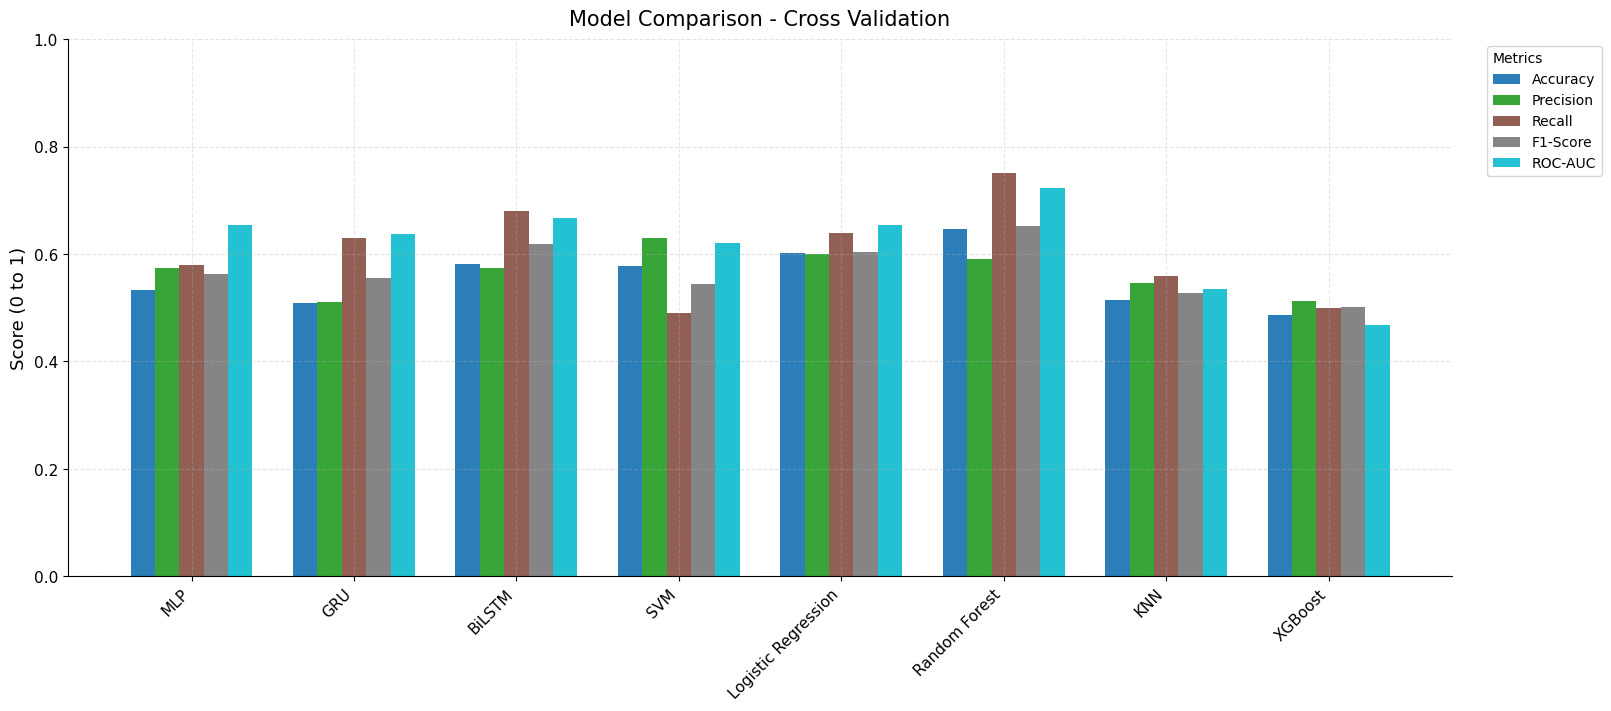

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Données et paramètres
# -----------------------------
metrics      = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy',  'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
# Ordre et noms de modèles
models = list(models_to_evaluate.keys())

# Couleurs proches de ton exemple (Matplotlib tab10)
colors = {
    'Accuracy' : '#1f77b4',  # bleu
    'Precision': '#2ca02c',  # vert
    'Recall'   : '#8c564b',  # brun
    'F1-Score' : '#7f7f7f',  # gris
    'ROC-AUC'  : '#17becf',  # cyan
}

# -----------------------------
# Tracé
# -----------------------------
fig_width = max(14, 1.0 * len(models) + 8)
plt.figure(figsize=(fig_width, 7), layout='constrained')

bar_width   = 0.15
x           = np.arange(len(models))
n_metrics   = len(metrics)
group_shift = (n_metrics - 1) * bar_width / 2

for i, (m, label) in enumerate(zip(metrics, metric_names)):
    vals      = [all_results[model][f'{m}_mean'] for model in models]
    positions = x - group_shift + i * bar_width
    plt.bar(positions, vals, width=bar_width, label=label, color=colors[label], alpha=0.95)

# Titres et axes
plt.title('Model Comparison - Cross Validation', fontsize=15, pad=10)
plt.ylabel('Score (0 to 1)')
plt.xticks(x, models, rotation=45, ha='right')
plt.ylim(0, 1.0)

# Grille légère sur Y
plt.grid(axis='y', linestyle='--', alpha=0.35)

# Légende à droite (comme l’image)
legend = plt.legend(title='Metrics',
                    loc='upper left', bbox_to_anchor=(1.02, 1.0),
                    frameon=True)
legend._legend_box.align = "left"  # aligne le texte sous le titre

plt.show()
